### Intro
* Replication for paper [Hoping for A to Z While Rewarding Only A: Complex Organizations and Multiple Goals](https://pubsonline.informs.org/doi/10.1287/orsc.1080.0358) by S.Ethiraj and D.Levinthal on OS in 2009.
* Research question comes from:
  1. Empirical finding on the negative relation between multiple goals and organization performance
  2. The reality that most organizations still have multiple goals
  3. How to alleviate the paradox
* Multiple goals:
  1. Different individuals face different intermediate goals, e.g. reducing manufacture cost,increasing customer loyalty. A single individual face multiple intermediate goals, e.g. manufacture department is required to enhance productivity of current product and to invest on new production line. 
  2. The map function between action and goal is not an one-to-one function but a one-to-many function, e.g. action to increase productivity of current product would potentially harm the R&D of new products.  
  3. Individuals can hardly integrate different goals into one measurable scale. 
* Proposed stategy:
  1. myopic strategy -> only focus on single goal and ignore remains
  2. spatial separation strategy -> each department focuses on one goal
  3. temporal separation strategy -> the whole organization focuses on one goal and switch to other goals periodically

### NK model
###### Notation
\begin{array}{c}
\ firm\ decision\ space\ f=\{d_1,d_2,...d_N\}\\
\ firm\ performance\ goals\ G=\{p_1,p_2,...p_G\}\\
\ performance\ contribution\ for\ ith\ decision\ on\ gth\ goal\ w_{ig}=w_{ig}(d_i;D_i)\\
\ firm\ performance\ on\ gth\ goal\ \Omega_g = \frac{1}{N} \sum_{i=1}^N w_{ig}(d_i;D_i)\\
\ firm\ performance\ \Omega = \frac{1}{G} \sum_{g=1}^G \Omega_g
\end{array}
###### Performance Improvement through action
$$
d_{j(t+1)}=\begin{cases}
d^{'}_{jt},&if\ \Omega^{'}_{gt} > \Omega_{gt} \\ 
d_{jt},&otherwise \\
\end{cases} 
\forall g=\{1,...,G\}
\tag{4.2}
$$  
###### Organization structures 
$$
M\ departments, each\ department\ has\ N/M\ decision:\\
m_k = \{d_{(k-1)(N/M)+1}...d_{k(N/M)}\}\\
R\ interdependecies\ are\ added\ and\ make\ sure\ within-deparment\ interdependencies\ are\ greater\ than\ between-department\ interdependencies.\ For\ those\ organizations\ with\ low\ R\ values,\ we\ regard\ them\ as\ simple\ organizations.\ Otherwise\ they\ are\ complex\ organizations\\
$$
###### Strategy 
1. Temporal separation strategy, managerical actions are evaluated for their efficacy based on deparmental performance improvement
$$
d_{j(t+1)}=\begin{cases}
d^{'}_{jt},&if\ \Omega^{'}_{pt(k)} > \Omega_{pt(k)} \\ 
d_{jt},&otherwise \\
\end{cases} 
\tag{4.4}
$$
2. Myopia strategy, a special case for temporal separation strategy where goal never changes
3. Spatial separation strategy, a special case for temporal separation strategy where goals are assigned to each depatment and remain unchanged

### Simulation

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict

In [90]:
def createInfluenceMatrix(decisionNum, departmentNum,inDepartmentInterdependenceNum, 
                          betweenDepartInterdependenceNum):
    decisions = [[j*(decisionNum//departmentNum)+i for i in range(decisionNum//departmentNum)] 
                 for j in range(departmentNum)]
    flat_decisions = [i for i in range(decisionNum)]

    withinDependency = []
    betweenDependency = []
    
    for d in decisions:
        for i in range(len(d)):
            for j in range(len(d)):
                if i==j:
                    continue
                else:
                    withinDependency.append((d[i],d[j]))
    
    temp = set(withinDependency)
    for i in range(len(flat_decisions)):
        for j in range(len(flat_decisions)):
            if i==j or (flat_decisions[i],flat_decisions[j]) in temp:
                continue
            else:
                betweenDependency.append((flat_decisions[i],flat_decisions[j]))
                
    
    within_index = np.random.choice([i for i in range(len(withinDependency))], 
                                    inDepartmentInterdependenceNum, replace=False)
    between_Index = np.random.choice([i for i in range(len(betweenDependency))], 
                                     betweenDepartInterdependenceNum, replace=False)
    
    IM = np.eye(decisionNum)
    
    for index in within_index:
        x,y = withinDependency[index]
        IM[x][y] = 1
    for index in between_Index:
        x,y = betweenDependency[index]
        IM[x][y] = 1
        
    IM_dic = defaultdict(list)
    for i in range(len(IM)):
        for j in range(len(IM[0])):
            if i==j or IM[i][j]==0:
                continue
            else:
                IM_dic[i].append(j)
    return IM,IM_dic

In [85]:
def createFitnessConfig(IM, goalNum):
    FC = []
    for goal in range(goalNum):
        temp_FC = defaultdict(dict)
        for row in range(len(IM)):
            k = int(sum(IM[row]))
            for i in range(pow(2,k)):
                temp_FC[row][i] = np.random.uniform(0,1)
        FC.append(temp_FC)
    return FC

In [103]:
FC = createFitnessConfig(IM,1)

In [136]:
def calculate_Fitness(state,IM_dic,FitnessConfig):
    res = 0.0
    for i in range(len(state)):
        dependency = IM_dic[i]
        bin_index = "".join([str(state[j]) for j in dependency])
        if state[i]==0:
            bin_index = "0" + bin_index
        else:
            bin_index = "1" + bin_index
        index = int(bin_index,2)
        res+=FitnessConfig[i][index]
    return res/len(state)

In [131]:
def initializeState(decisionNum):
    return np.random.choice([0,1],decisionNum)

In [132]:
s = initializeState(24)

###### Baseline  
Randomly choose a department to take random action in each period and adpot the action if the fitness level follows formula 4.2

In [142]:
def baselineSimulation(decisionNum, departmentNum,inDepartmentInterdependenceNum, betweenDepartInterdependenceNum, 
                       goalNum, agentNum, iteration):
    res = []
    for agent in range(agentNum):
        temp_res = []
        IM,IM_dic = createInfluenceMatrix(decisionNum,departmentNum,inDepartmentInterdependenceNum,
                                          betweenDepartInterdependenceNum)
        FCs = createFitnessConfig(IM,goalNum)
        state = initializeState(decisionNum)
        
        temp_res.append(np.mean([calculate_Fitness(state,IM_dic,FCs[goal]) for goal in range(goalNum)]))
        
        for step in range(iteration):
            # local search for baseline
            temp_state = list(state)
            decision_index = np.random.choice([i for i in range(decisionNum)],1)[0]
            temp_state[decision_index] = temp_state[decision_index]^1
            tag = True
            for goal in range(goalNum):
                if calculate_Fitness(state,IM_dic,FCs[goal])>calculate_Fitness(temp_state,IM_dic,FCs[goal]):
                    tag = False
                    break
            if tag:
                state = temp_state
            temp_res.append(np.mean([calculate_Fitness(state,IM_dic,FCs[goal]) for goal in range(goalNum)]))
        res.append(temp_res)
    return np.array(res)

In [150]:
res = baselineSimulation(24,4,0,0,8,250,250)

In [154]:
baseline_simple_org = [np.mean(baselineSimulation(24,4,0,0,i,250,250),axis=0)[-1] for i in [1,2,4,8]]
baseline_complex_org = [np.mean(baselineSimulation(24,4,90,30,i,250,250),axis=0)[-1] for i in [1,2,4,8]]

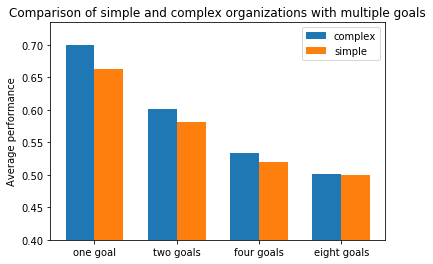

In [173]:
labels = ["one goal", "two goals", "four goals", "eight goals"]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x-width/2, baseline_complex_org, width, label="complex")
rects2 = ax.bar(x+width/2, baseline_simple_org, width, label="simple")

ax.set_title("Comparison of simple and complex organizations with multiple goals")
ax.set_ylabel("Average performance")
ax.set_ylim(ymin=0.4)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

###### Intuition from baseline
* As the number of goals increases, the likelihood that an action will reduce at least one performance goal also increases and thus reduces the probability of engaging in performance improvement efforts.
* Interdependencies across decisions in the complex organization act to perturb the organization and get it off inferior local peaks. This beneﬁt, however, disappears with an increase in the number of goals, suggesting that the effect of number of goals swamps the effect of decision interdependence in organizations.
* **Coordination challenges do exist in organizations!**

###### Myopia strategy
Randomly fix a goal for the whole organization. In each epoch, randomly choose a department to take action and the action would be adopted if the fitness level follows formula 4.4

In [163]:
def myopiaSimulation(decisionNum, departmentNum,inDepartmentInterdependenceNum, betweenDepartInterdependenceNum, 
                       goalNum, agentNum, iteration):
    res = []
    for agent in range(agentNum):
        temp_res = []
        IM,IM_dic = createInfluenceMatrix(decisionNum,departmentNum,inDepartmentInterdependenceNum,
                                          betweenDepartInterdependenceNum)
        FCs = createFitnessConfig(IM,goalNum)
        state = initializeState(decisionNum)
        
        temp_res.append(np.mean([calculate_Fitness(state,IM_dic,FCs[goal]) for goal in range(goalNum)]))
        
        fixed_goal = np.random.choice([i for i in range(goalNum)],1)[0]
        
        for step in range(iteration):
            # local search for myopia strategy
            temp_state = list(state)
            decision_index = np.random.choice([i for i in range(decisionNum)],1)[0]
            temp_state[decision_index] = temp_state[decision_index]^1
            
            if calculate_Fitness(state, IM_dic, FCs[fixed_goal])<calculate_Fitness(
                temp_state, IM_dic, FCs[fixed_goal]):
                state = temp_state
            temp_res.append(np.mean([calculate_Fitness(state,IM_dic,FCs[goal]) for goal in range(goalNum)]))
        res.append(temp_res)
    return np.array(res)

In [165]:
res = myopiaSimulation(24,4,90,30,8,250,250)

In [168]:
myopia_complex_org = [np.mean(myopiaSimulation(24,4,90,30,i,250,250),axis=0)[-1] for i in [1,2,4,8]]

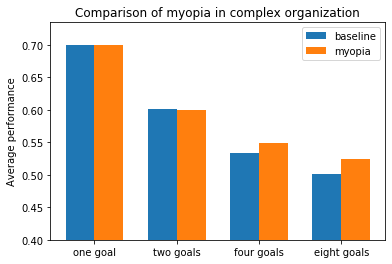

In [172]:
labels = ["one goal", "two goals", "four goals", "eight goals"]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x-width/2, baseline_complex_org, width, label="baseline")
rects2 = ax.bar(x+width/2, myopia_complex_org, width, label="myopia")

ax.set_title("Comparison of myopia in complex organization")
ax.set_ylabel("Average performance")
ax.set_ylim(ymin=0.4)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

###### Intuition from myopia
* Focusing on only one goal in evaluating incremental search attempts helps break the conﬂicting constraints that emanate from trying to satisfy multiple goals, thus helping overcome the status quo trap. 
* As the number of ignored goals increases, however, the overall improvement from focusing on a single goal declines considerably.

###### Spatial separation strategy
Assign certain (one or two) goal to a department and adopt department level action based on formula 4.4

In [189]:
def spatialSimulation(decisionNum, departmentNum,inDepartmentInterdependenceNum, betweenDepartInterdependenceNum, 
                       goalNum, agentNum, iteration):
    res = []
    for agent in range(agentNum):
        temp_res = []
        IM,IM_dic = createInfluenceMatrix(decisionNum,departmentNum,inDepartmentInterdependenceNum,
                                          betweenDepartInterdependenceNum)
        FCs = createFitnessConfig(IM,goalNum)
        state = initializeState(decisionNum)
        
        temp_res.append(np.mean([calculate_Fitness(state,IM_dic,FCs[goal]) for goal in range(goalNum)]))
        
        # goal assignment
        goals = np.random.choice([i for i in range(goalNum)],goalNum,replace=False)
        goal_for_each_depart = goalNum//departmentNum
        
        for step in range(iteration):
            # local search for spatial separation strategy
            
            temp_state = list(state)
            
            decision_index = np.random.choice(
                [i for i in range(decisionNum)],1)[0]
            temp_state[decision_index] = temp_state[decision_index]^1
            department = decision_index//(decisionNum//departmentNum)
            
            tag = True
            for goal in goals[department*goal_for_each_depart:(department+1)*goal_for_each_depart]:
                if calculate_Fitness(state,IM_dic,FCs[goal])>calculate_Fitness(temp_state,IM_dic,FCs[goal]):
                    tag = False
                    break
            if tag:
                state = temp_state
                
            temp_res.append(np.mean([calculate_Fitness(state,IM_dic,FCs[goal]) for goal in range(goalNum)]))
        res.append(temp_res)
    return np.array(res)

In [185]:
res = spatialSimulation(24,4,90,30,8,250,250)

In [190]:
spatial_complex_org = [np.mean(spatialSimulation(24,4,90,30,i,250,250),axis=0)[-1] for i in [4,8]]

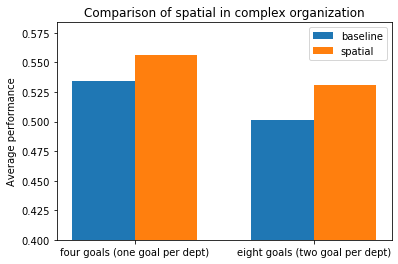

In [193]:
labels = ["four goals (one goal per dept)", "eight goals (two goal per dept)"]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x-width/2, baseline_complex_org[2:], width, label="baseline")
rects2 = ax.bar(x+width/2, spatial_complex_org, width, label="spatial")

ax.set_title("Comparison of spatial in complex organization")
ax.set_ylabel("Average performance")
ax.set_ylim(ymin=0.4)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

###### Intuition from spatial
* Even though one department’s actions can undermine the performance goals of other departments, the myopic actions of each department are sufﬁcient to improve the average performance of the ﬁrm on all goals.

###### Temporal separation strategy
* the whole organization would focus on one goal and switch to other goals periodically

In [220]:
def temporalSimulation(decisionNum, departmentNum,inDepartmentInterdependenceNum, betweenDepartInterdependenceNum, 
                       goalNum, agentNum, iteration):
    res = []
    for agent in range(agentNum):
        temp_res = []
        IM,IM_dic = createInfluenceMatrix(decisionNum,departmentNum,inDepartmentInterdependenceNum,
                                          betweenDepartInterdependenceNum)
        FCs = createFitnessConfig(IM,goalNum)
        state = initializeState(decisionNum)
        
        temp_res.append(np.mean([calculate_Fitness(state,IM_dic,FCs[goal]) for goal in range(goalNum)]))
        
        # goal order
        epoch = math.ceil(iteration//goalNum)
        if epoch*goalNum<iteration:
            epoch+=1
        
        for step in range(iteration):
            # local search for temporal separation strategy
            
            temp_state = list(state)
            
            decision_index = np.random.choice(
                [i for i in range(decisionNum)],1)[0]
            temp_state[decision_index] = temp_state[decision_index]^1
            goal_index = step//epoch
            
            if calculate_Fitness(state, IM_dic, FCs[goal_index])<calculate_Fitness(
                temp_state, IM_dic, FCs[goal_index]):
                state = temp_state
            temp_res.append(np.mean([calculate_Fitness(state,IM_dic,FCs[goal]) for goal in range(goalNum)]))
        res.append(temp_res)
    return np.array(res)

In [209]:
res = temporalSimulation(24,4,90,30,8,250,250)

In [221]:
temporal_complex_org = [np.mean(temporalSimulation(24,4,90,30,i,250,250),axis=0) for i in [4,8]]

In [222]:
temporal_complex_org[0].shape

(251,)

In [215]:
baseline_complex_org_seq = [np.mean(baselineSimulation(24,4,90,30,i,250,250),axis=0) for i in [4,8]]

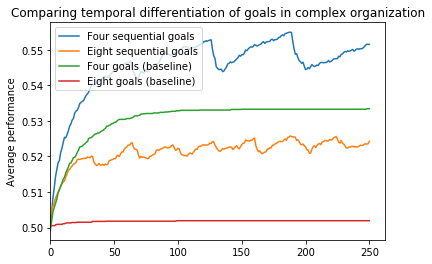

In [230]:
plt.plot(temporal_complex_org[0],label="Four sequential goals")
plt.plot(temporal_complex_org[1],label="Eight sequential goals")
plt.plot(baseline_complex_org_seq[0],label="Four goals (baseline)")
plt.plot(baseline_complex_org_seq[1],label="Eight goals (baseline)")
plt.xlim(0)
plt.title("Comparing temporal differentiation of goals in complex organization")
plt.ylabel("Average performance")
plt.legend()
plt.show()

###### Intuition from temporal separation strategy
* Temporal differentiation of goals results in significant overall ﬁrm performance improvement across all G goals.
* Firm has reached a local peak on the assigned performance goal, and a shift to a new performance goal triggers a fall in overall ﬁrm performance, primarily due to a performance decline on the prior goal.
* The process of local search to generate performance improvement on a complex performance landscape is extremely slow, and 32 simulation periods is insufﬁcient to generate signiﬁcant performance improvement.

### Possible Extension
* Establish a multiple goal perspective, but goals only have weak correaltion with each other.
* Alleviate the paradox on a strategy (goal setting) level, maybe we could solve the paradox on individual/department level, e.g. coordination, common interest & goals. 
* Further investigation on organization structure?
* Interorganizational phenomenon based on multiple goals?